# Machine Learning 4 - Classification

In this example we continue with the hotel dataset example and we will try to predict the cancellation rate using 3 Machine Learning models.

**Problem**

We have data on reservations made for two hotels in Portugal, and we are interested in knowing data on how many reservations were canceled, where the largest number of guests come from, how long they stay on average, etc.

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

**Install libraries**

In [ ]:
# instalación de librerías
#!pip install pycountry
!pip install missingno
!pip install scikit-learn

In [ ]:
# data analytics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

# machine learning (scikit-learn)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# miscellaneous
import os
import missingno as msno
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")

For this example we will use the "Hotel Cancellations" dataset from Kaggle (https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction).

In [ ]:
filepath = 'Hotel_Kaggle.csv'

# si existe el archivo
if os.path.exists(filepath):
  df = pd.read_csv(filepath)
  print('Dataset cargado correctamente')

Dataset cargado correctamente


## 1. Data Preprocessing

**Preliminary exploration**

In [ ]:
df.head(10)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,2,Resort Hotel,0,737,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,3,Resort Hotel,0,7,2015,July,27,1,0,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,4,Resort Hotel,0,13,2015,July,27,1,0,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,5,Resort Hotel,0,14,2015,July,27,1,0,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015
5,6,Resort Hotel,0,14,2015,July,27,1,0,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015
6,7,Resort Hotel,0,0,2015,July,27,1,0,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,3/7/2015
7,8,Resort Hotel,0,9,2015,July,27,1,0,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,3/7/2015
8,9,Resort Hotel,1,85,2015,July,27,1,0,3,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,6/5/2015
9,10,Resort Hotel,1,75,2015,July,27,1,0,3,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,22/04/2015


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   is_canceled                     119390 non-null  int64  
 3   lead_time                       119390 non-null  int64  
 4   arrival_date_year               119390 non-null  int64  
 5   arrival_date_month              119390 non-null  object 
 6   arrival_date_week_number        119390 non-null  int64  
 7   arrival_date_day_of_month       119390 non-null  int64  
 8   stays_in_weekend_nights         119390 non-null  int64  
 9   stays_in_week_nights            119390 non-null  int64  
 10  adults                          119390 non-null  int64  
 11  children                        119386 non-null  float64
 12  babies          

**Null values**

In [ ]:
# identificar porcentaje de nulos por columna
for col in df.columns:
  if df[col].isnull().values.any():
    print({'Columns with nulls' : col, 'Percentage of nulls' : round(df[col].isnull().sum()/df.shape[0]*100, 4)})

{'Columnas con nulos': 'children', 'Porcentaje de nulos': 0.0034}
{'Columnas con nulos': 'country', 'Porcentaje de nulos': 0.4087}
{'Columnas con nulos': 'agent', 'Porcentaje de nulos': 13.6862}
{'Columnas con nulos': 'company', 'Porcentaje de nulos': 94.3069}


We can use the MissingNo library to display null data points.

<Axes: >

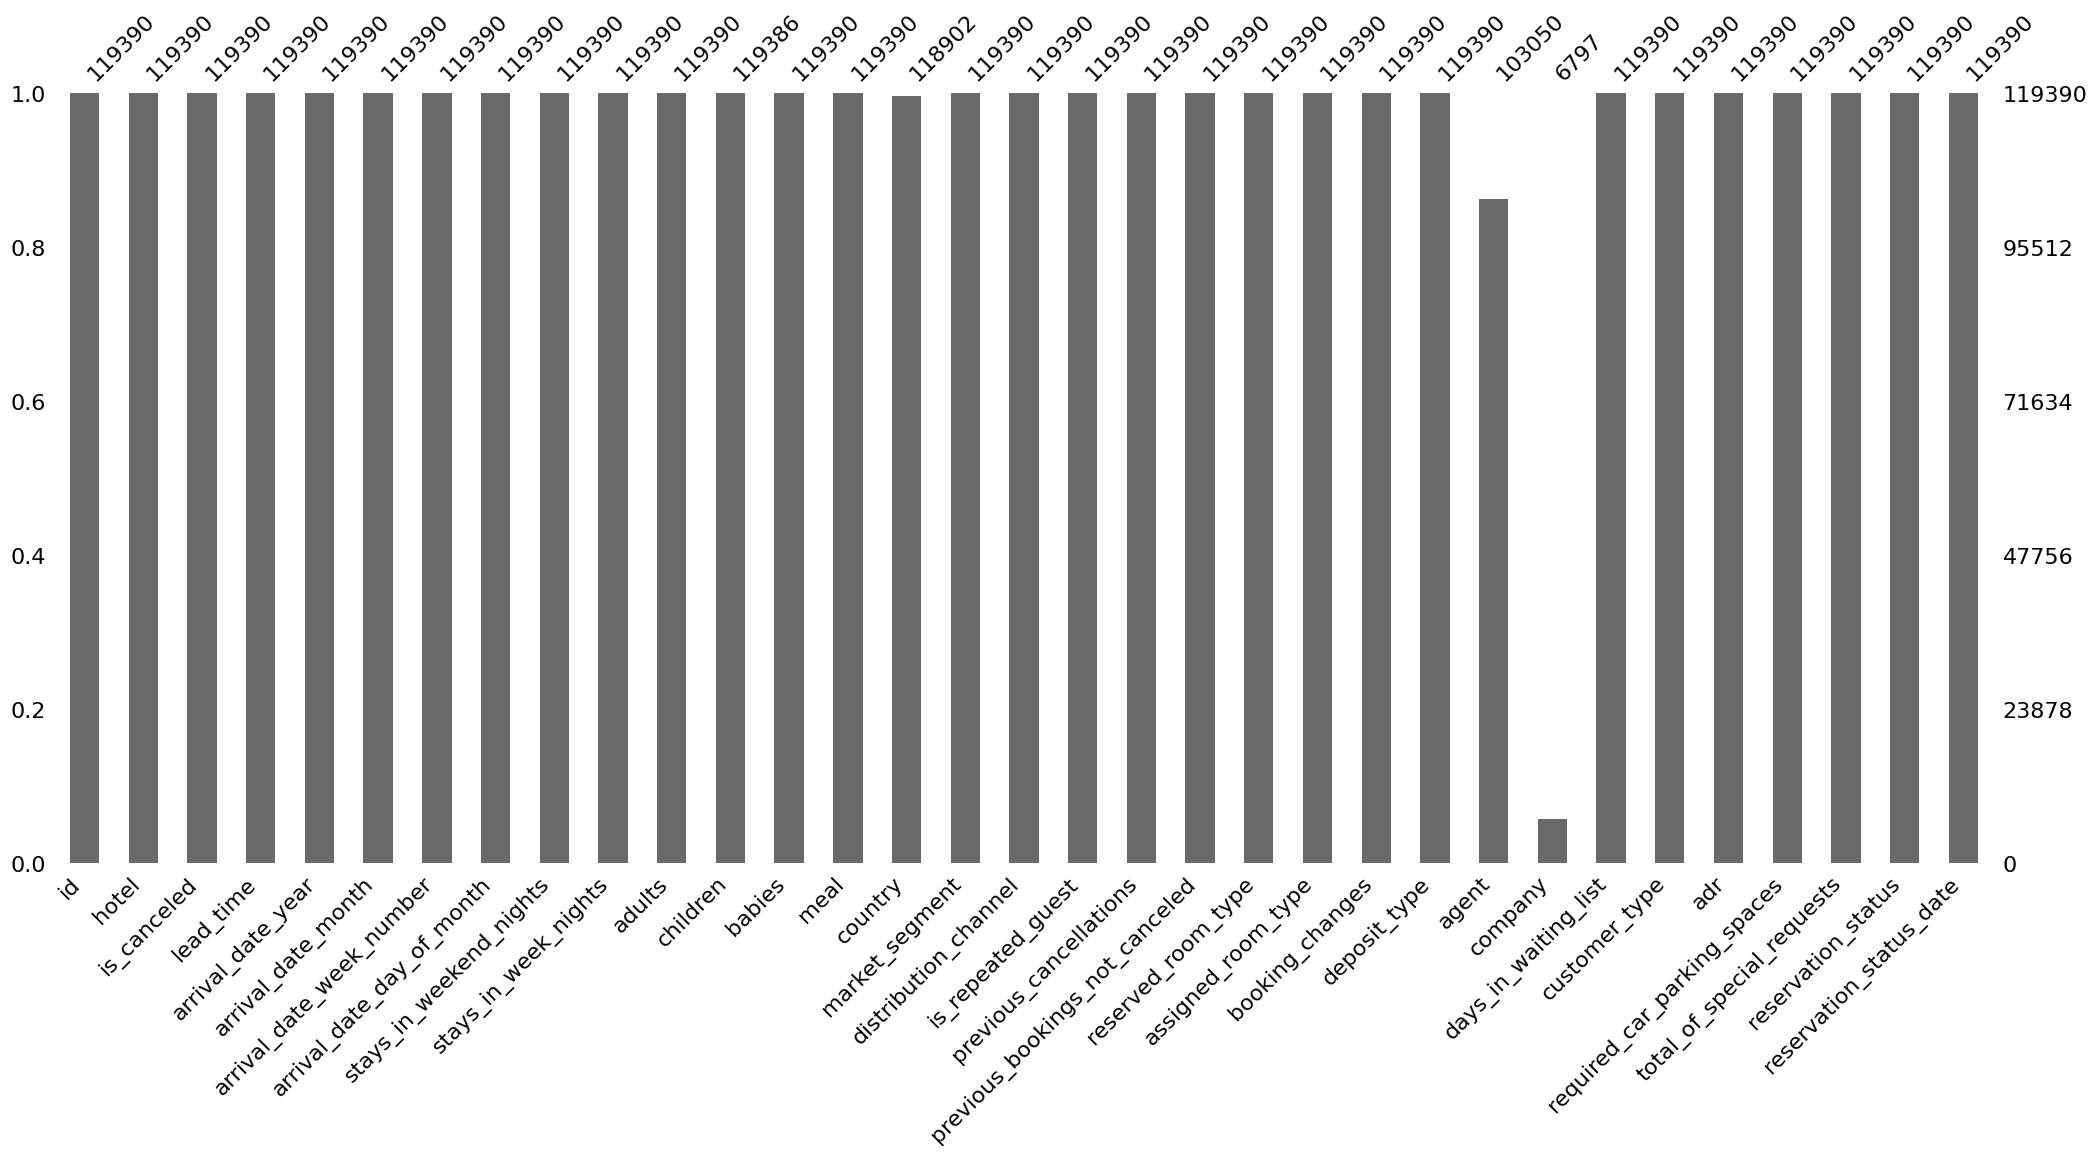

In [ ]:
# displaying null values: bar chart
msno.bar(df)

The 'children', 'country', 'agent' and 'company' columns are the only ones with missing data. We observed notable correlation between the 'company' and 'agent' columns. Because?

For 'company' almost all values ​​are null, so it is advisable to eliminate the column. For the rest, we substitute null values.

In [ ]:
# delete column 'company'
df = df.drop('company', axis=1)

# replace NaN in 'children'
df['children'] = df['children'].fillna(0)

# replace NaN in 'country'
df['country'] = df['country'].replace(np.nan,'UNKNOWN')

# replace NaN in 'agent'
df['agent'] = df['agent'].fillna(0)

# reset indices
df.reset_index(inplace=True)

In [ ]:
# verify we no longer have null values
df.isnull().values.any()

False

**Outliers**

In [ ]:
df.describe()

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59694.500000,59695.500000,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,...,0.007949,0.031912,0.087118,0.137097,0.221124,74.828319,2.321149,101.831122,0.062518,0.571363
std,34465.068657,34465.068657,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,...,0.097436,0.175767,0.844336,1.497437,0.652306,107.141953,17.594721,50.535790,0.245291,0.792798
min,0.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,29847.250000,29848.250000,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,69.290000,0.000000,0.000000
50%,59694.500000,59695.500000,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,94.575000,0.000000,0.000000
75%,89541.750000,89542.750000,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,126.000000,0.000000,1.000000
max,119389.000000,119390.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,...,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000


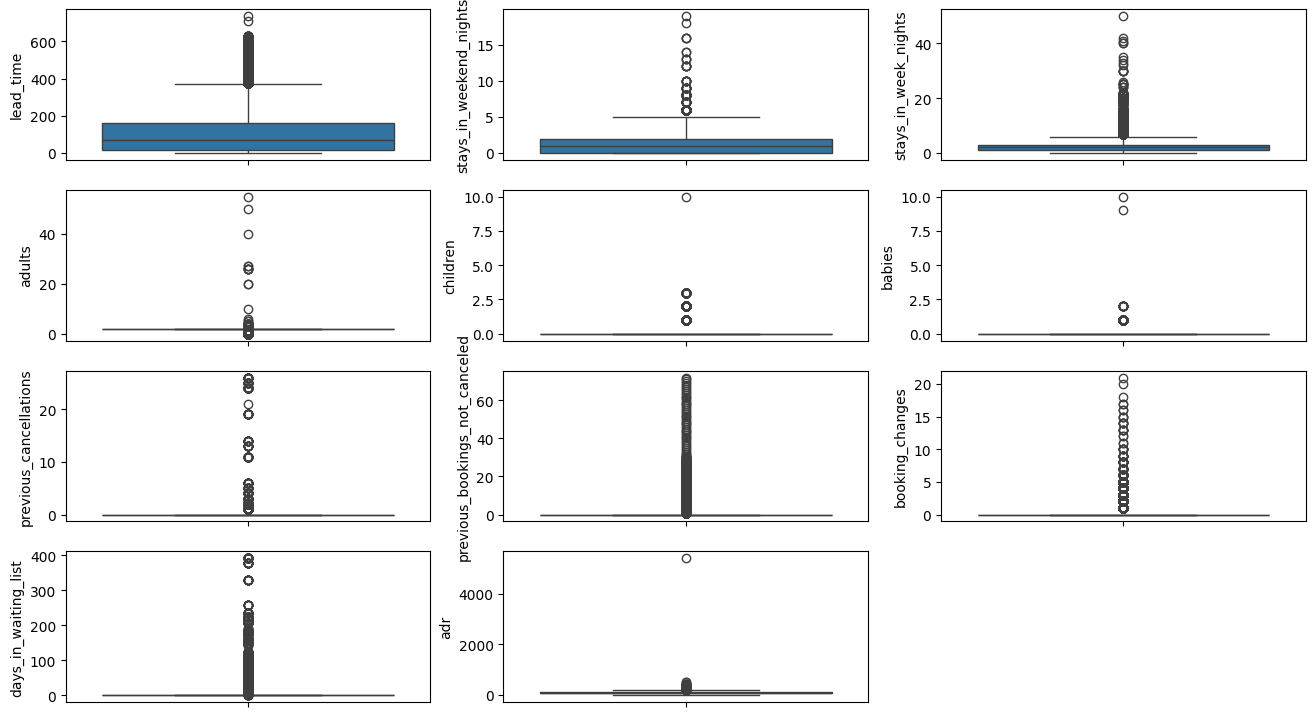

In [ ]:
# definir las columnas con outliers potenciales
out_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
            'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
            'booking_changes', 'days_in_waiting_list', 'adr']

plt.figure(figsize=(16,9))

# graficar boxplots en grupos
# enumerate: 1er valor es el índice (entero), 2do valor es el valor de la lista (str/num/etc.)
for i, col in enumerate(out_cols):
  plt.subplot(4,3,i+1) # i empieza en 0
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

With the exception of 'booking_changes' most columns have a small percentage of extreme values ​​(5% or less). However, in order not to have to completely eliminate the columns where they appear, we can treat these extreme values ​​using conditionals (we choose the limit values ​​with the help of the boxplots).

In [ ]:
# limit outliers
df.loc[df['lead_time'] > 600, 'lead_time'] = 600
df.loc[df['stays_in_weekend_nights'] > 7, 'stays_in_weekend_nights'] = 7
df.loc[df['stays_in_week_nights'] > 10, 'stays_in_week_nights'] = 10
df.loc[df['adults'] > 5, 'adults'] = 5
df.loc[df['children'] > 3, 'children'] = 3
df.loc[df['babies'] > 2, 'babies'] = 2
df.loc[df['previous_cancellations'] > 5, 'previous_cancellations'] = 5
df.loc[df['previous_bookings_not_canceled'] > 0, 'previous_bookings_not_canceled'] = 1
df.loc[df['booking_changes'] > 5, 'booking_changes'] = 5
df.loc[df['days_in_waiting_list'] > 100, 'days_in_waiting_list'] = 100
df.loc[df['adr'] > 1000, 'adr'] = 1000

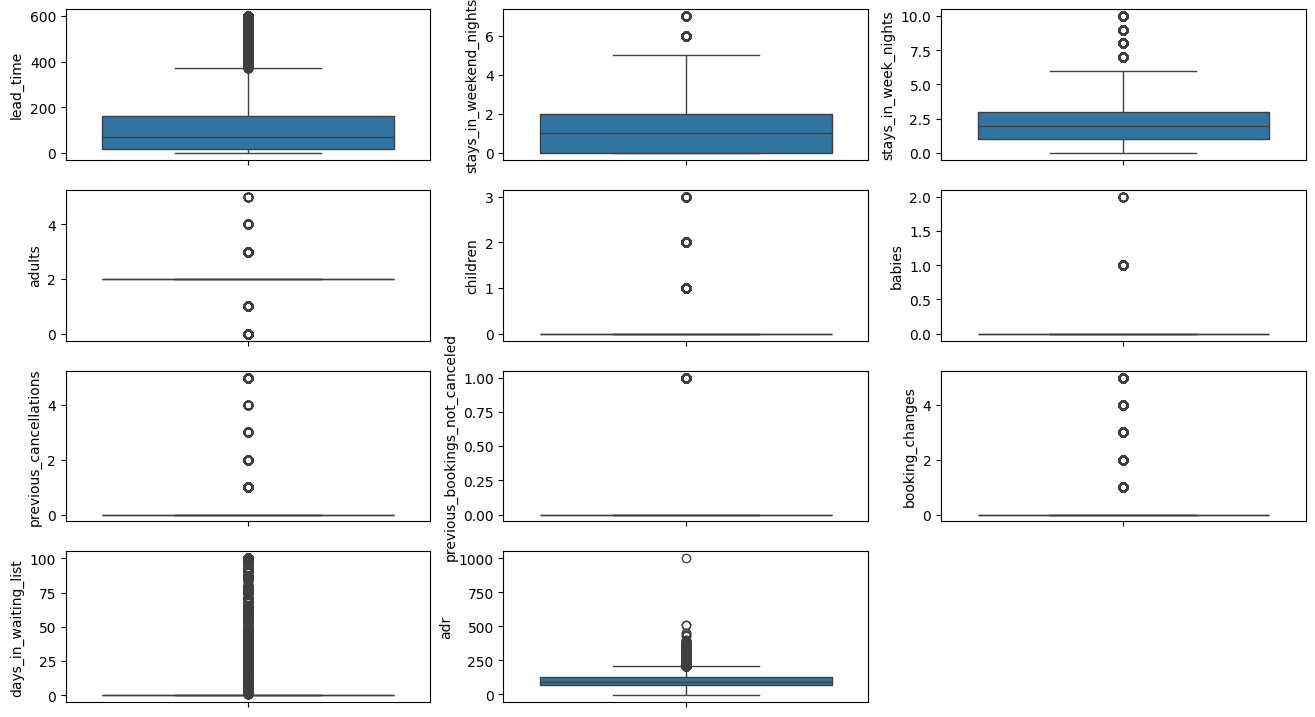

In [ ]:
# define columns with potential outliers
out_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
            'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
            'booking_changes', 'days_in_waiting_list', 'adr']

plt.figure(figsize=(16,9))

# graph boxplots by groups
for i, col in enumerate(out_cols):
  plt.subplot(4,3,i+1)
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

## Predictive Model (Pre-processing)

Before proceeding to build the architectures, it is necessary to prepare the data and perform the selection of relevant features for the prediction of our target feature.

In [ ]:
# copy dataset
data = df.copy()

**Data leakage**

One of the most common mistakes in modeling is trying to consider as input to the model, data that will not necessarily be available at the time the model is in production.

In [ ]:
# posible reservation states
data['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

Analyzing the columns available in the dataset, we see that the only column that can cause this information leak would be the reservation status ('reservation_status'). If we look at the values ​​that this column can have ('Check-Out', 'Canceled', 'No-Show'), it is evident that the reservation status almost always implies a posteriori knowledge that the client has canceled or not, when that is what we want to predict in the first place. Therefore, we remove that column from the input data.

In [ ]:
data.drop('reservation_status', axis=1, inplace=True)

**Timestamp splitting**

The 'reservation_status_date' column is a date that cannot be processed in that status. Therefore, we must first convert it to a time stamp (*timestamp*) and then separate it into its components.

In [ ]:
# we convert the column to timestamp type
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'], format='%d/%m/%Y')

# we separate the year, month and day
data['reservation_status_date_year'] = data['reservation_status_date'].dt.year
data['reservation_status_date_month'] = data['reservation_status_date'].dt.month
data['reservation_status_date_day'] = data['reservation_status_date'].dt.day

# we delete the original column
data.drop('reservation_status_date', axis=1, inplace=True)

In [ ]:
data.head(5)

,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day
0,0,1,Resort Hotel,0,342,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,0.0,0,0,2015,7,1
1,1,2,Resort Hotel,0,600,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,0.0,0,0,2015,7,1
2,2,3,Resort Hotel,0,7,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,75.0,0,0,2015,7,2
3,3,4,Resort Hotel,0,13,2015,July,27,1,0,...,No Deposit,304.0,0,Transient,75.0,0,0,2015,7,2
4,4,5,Resort Hotel,0,14,2015,July,27,1,0,...,No Deposit,240.0,0,Transient,98.0,0,1,2015,7,3


**Coding of categorical variables (pre-splitting)**

In order to analyze the correlation of variables, it is necessary to encode categorical variables into numerical variables. We start by identifying the columns with categorical variables.

In [ ]:
# columns with categorical variables
cat_cols = list(data.columns[data.dtypes == 'O'])
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [ ]:
# we identify the unique values ​​of each categorical column
for c in cat_cols:
  uni_cols = data[c].unique()
  print(c, '(', len(uni_cols), ') : ', uni_cols)

hotel ( 2 ) :  ['Resort Hotel' 'City Hotel']
arrival_date_month ( 12 ) :  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal ( 5 ) :  ['BB' 'FB' 'HB' 'SC' 'Undefined']
country ( 178 ) :  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'UNKNOWN' 'ROU' 'NOR' 'OMN' 'ARG'
 'POL' 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS'
 'EST' 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX'
 'MAR' 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF'
 'AGO' 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN'
 'JAM' 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'
 'GGY' 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL'
 'SEN' 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA'
 'CUB' 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP'
 'BDI' 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL'
 'UZB' 'NPL' 'BHS' 

To transform categorical variables, it is necessary to consider different coding methods.

When we have a clear hierarchy in the variables (as in the case of months or room type), it is convenient to apply *label encoding*. Likewise, this can be applied when we have categorical variables with high cardinality (as in the case of countries).

When we do not have a hierarchy between variables and/or we have low cardinality, it is convenient to apply *one-hot encoding*. However, in this case we must be careful with the dummy variable trap (*dummy variable trap*), since it may happen that the new columns present a high collinearity between them. To avoid this, we minimize the number of new columns created. As a general rule, we use one-hot encoding when we have a cardinality (e.g. unique values ​​of the variable) less than or equal to 10.

It is important to mention that coding is usually done **after training and validation sets**. Here we only do it to study the correlations and choose the characteristics that work best to predict the model, and we will repeat it once the separation of variables is done.

In [ ]:
data2 = data.copy()

# definir los categorical encoders
lbl_enc = LabelEncoder()
hot_enc = OneHotEncoder(drop='first', sparse=False) # dummy encoding

row_size = data2.shape[0]

data2.head(5)

,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day
0,0,1,Resort Hotel,0,342,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,0.0,0,0,2015,7,1
1,1,2,Resort Hotel,0,600,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,0.0,0,0,2015,7,1
2,2,3,Resort Hotel,0,7,2015,July,27,1,0,...,No Deposit,0.0,0,Transient,75.0,0,0,2015,7,2
3,3,4,Resort Hotel,0,13,2015,July,27,1,0,...,No Deposit,304.0,0,Transient,75.0,0,0,2015,7,2
4,4,5,Resort Hotel,0,14,2015,July,27,1,0,...,No Deposit,240.0,0,Transient,98.0,0,1,2015,7,3


In [ ]:
# encoding of 'hotel' (one-hot)
col_name = 'hotel'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (row_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
data2 = pd.concat([data2, col_df], axis=1)
data2.drop(col_name, axis=1, inplace=True)

data2.head(5)

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,hotel_type
0,0,1,0,342,2015,July,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
1,1,2,0,600,2015,July,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
2,2,3,0,7,2015,July,27,1,0,1,...,0.0,0,Transient,75.0,0,0,2015,7,2,1.0
3,3,4,0,13,2015,July,27,1,0,1,...,304.0,0,Transient,75.0,0,0,2015,7,2,1.0
4,4,5,0,14,2015,July,27,1,0,2,...,240.0,0,Transient,98.0,0,1,2015,7,3,1.0


In [ ]:
# encoding of 'arrival_date_month' (label)
col_name = 'arrival_date_month'
# manual encoding (mapping)
data2[col_name] = data2[col_name].map({'January': 0, 'February': 1,
                                       'March': 2, 'April': 3, 'May': 4,
                                       'June': 5, 'July': 6, 'August': 7,
                                       'September': 8, 'October': 9,
                                       'November': 10, 'December': 11})

data2.head(5)

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,hotel_type
0,0,1,0,342,2015,6,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
1,1,2,0,600,2015,6,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
2,2,3,0,7,2015,6,27,1,0,1,...,0.0,0,Transient,75.0,0,0,2015,7,2,1.0
3,3,4,0,13,2015,6,27,1,0,1,...,304.0,0,Transient,75.0,0,0,2015,7,2,1.0
4,4,5,0,14,2015,6,27,1,0,2,...,240.0,0,Transient,98.0,0,1,2015,7,3,1.0


In [ ]:
# encoding of 'country' (label)
col_name = 'country'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

data2.head(5)

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,hotel_type
0,0,1,0,342,2015,6,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
1,1,2,0,600,2015,6,27,1,0,0,...,0.0,0,Transient,0.0,0,0,2015,7,1,1.0
2,2,3,0,7,2015,6,27,1,0,1,...,0.0,0,Transient,75.0,0,0,2015,7,2,1.0
3,3,4,0,13,2015,6,27,1,0,1,...,304.0,0,Transient,75.0,0,0,2015,7,2,1.0
4,4,5,0,14,2015,6,27,1,0,2,...,240.0,0,Transient,98.0,0,1,2015,7,3,1.0


In [ ]:
# encoding of 'meal' (label)
col_name = 'meal'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'market_segment' (label)
col_name = 'market_segment'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'distribution_channel' (label)
col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'reserved_room_type' (label)
col_name = 'reserved_room_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'assigned_room_type' (label)
col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'deposit_type' (label)
col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'customer_type' (label)
col_name = 'customer_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# encoding of 'arrival_date_year' (label)
col_name = 'arrival_date_year'
data2[col_name] = data2[col_name].map({2015: 0, 2016: 1, 2017: 2})

# encoding of 'reservation_status_date_year' (label)
col_name = 'reservation_status_date_year'
data2[col_name] = data2[col_name].map({2015: 0, 2016: 1, 2017: 2})

In [ ]:
data2.head(5)

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,hotel_type
0,0,1,0,342,0,6,27,1,0,0,...,0.0,0,2,0.0,0,0,0.0,7,1,1.0
1,1,2,0,600,0,6,27,1,0,0,...,0.0,0,2,0.0,0,0,0.0,7,1,1.0
2,2,3,0,7,0,6,27,1,0,1,...,0.0,0,2,75.0,0,0,0.0,7,2,1.0
3,3,4,0,13,0,6,27,1,0,1,...,304.0,0,2,75.0,0,0,0.0,7,2,1.0
4,4,5,0,14,0,6,27,1,0,2,...,240.0,0,2,98.0,0,1,0.0,7,3,1.0


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   index                           119390 non-null  int64  
 1   id                              119390 non-null  int64  
 2   is_canceled                     119390 non-null  int64  
 3   lead_time                       119390 non-null  int64  
 4   arrival_date_year               119390 non-null  int64  
 5   arrival_date_month              119390 non-null  int64  
 6   arrival_date_week_number        119390 non-null  int64  
 7   arrival_date_day_of_month       119390 non-null  int64  
 8   stays_in_weekend_nights         119390 non-null  int64  
 9   stays_in_week_nights            119390 non-null  int64  
 10  adults                          119390 non-null  int64  
 11  children                        119390 non-null  float64
 12  babies          

**Variable correlation (Feature Selection)**

Taking into account that the column to predict is 'is_canceled', we will analyze which variables have the highest correlation coefficients with this characteristic.

In [ ]:
# delete 'id' as it's just an index
data2.drop('id', axis=1, inplace=True)
data2.drop('index', axis=1, inplace=True)

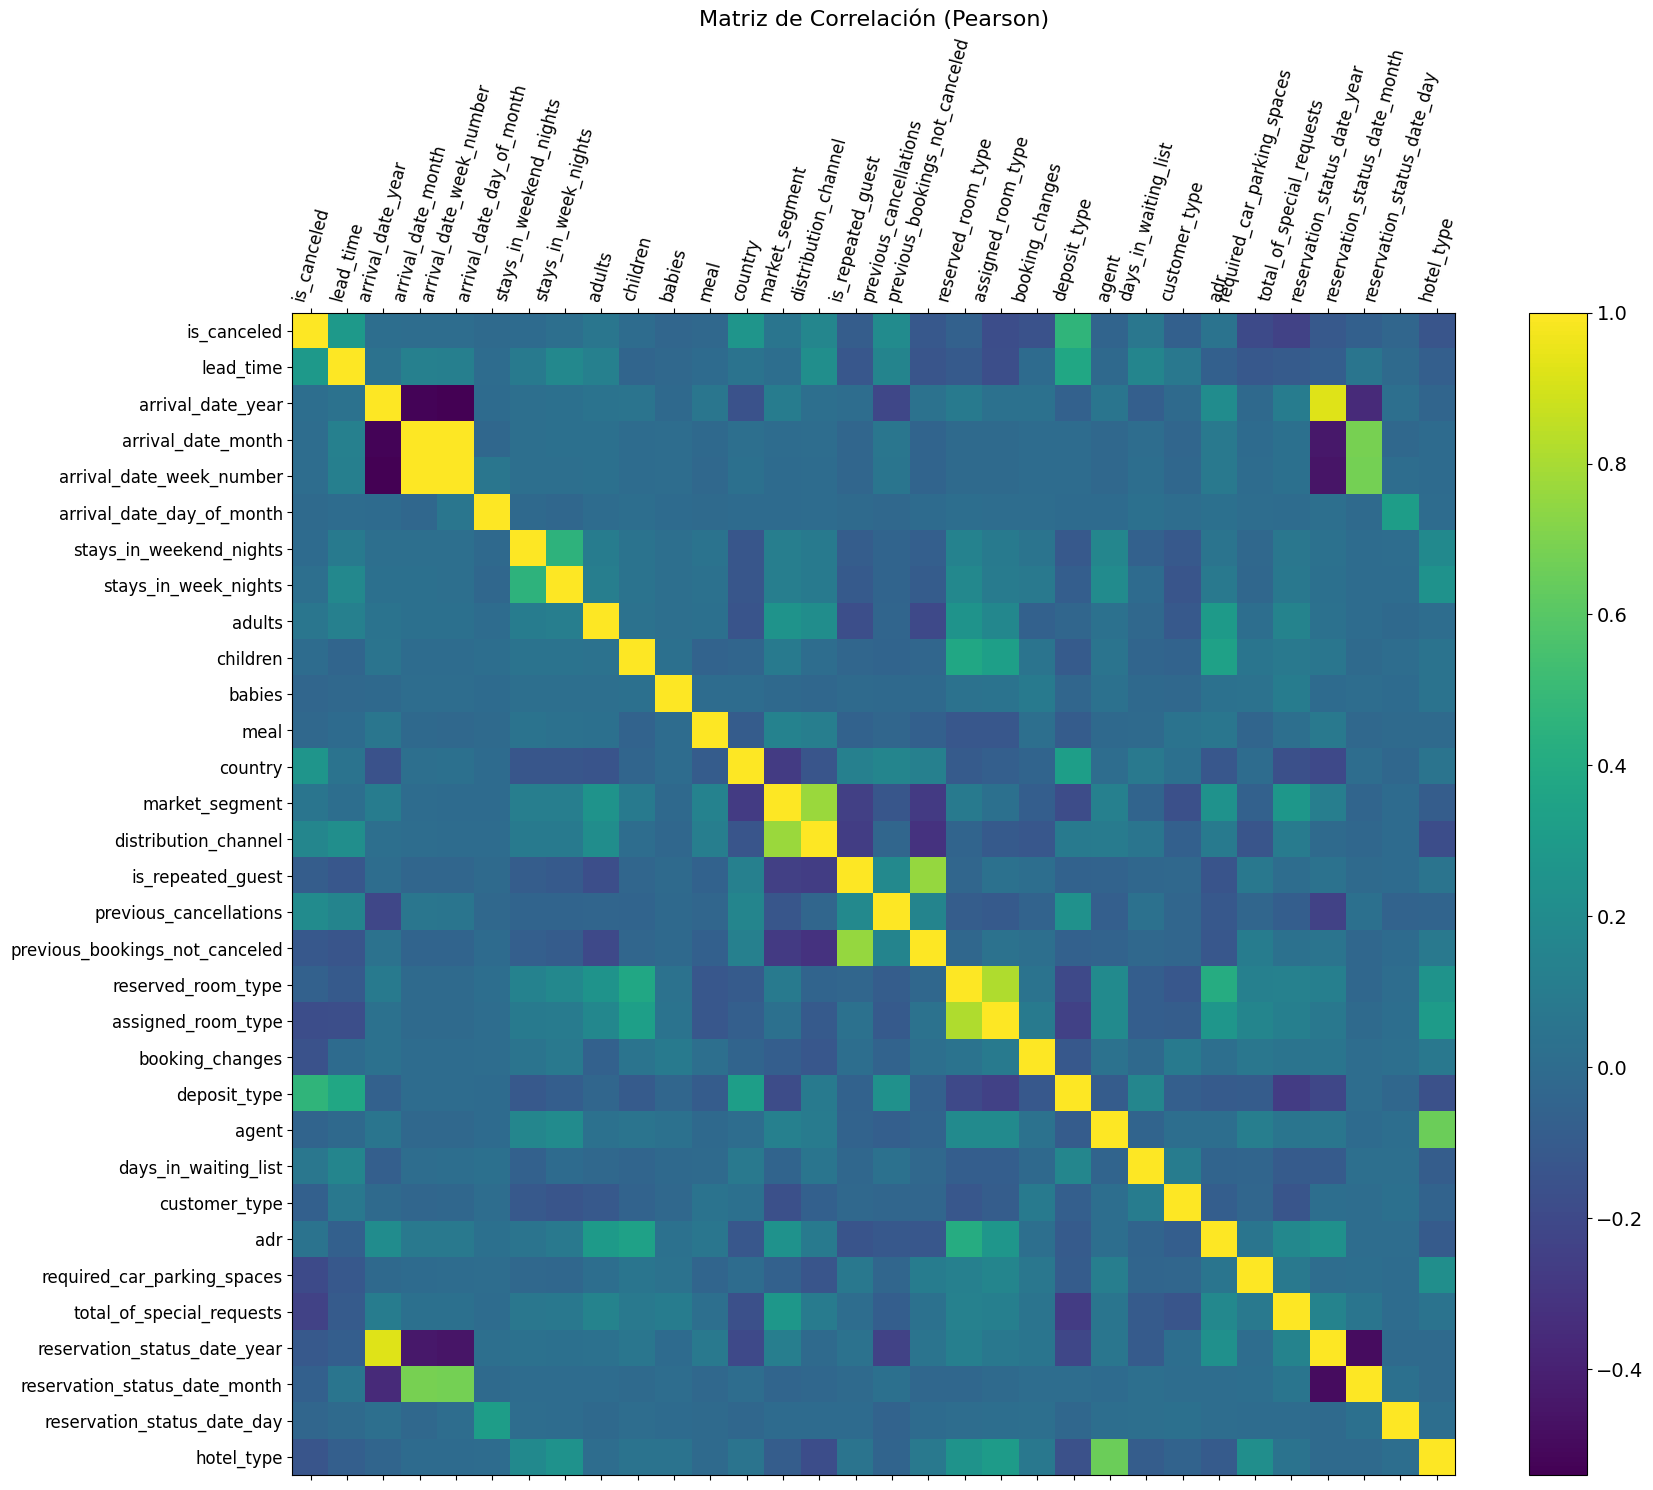

In [ ]:
# calculate correlation matrix
corr_matrix = data2.corr('pearson')

# plot correlation matrix
fig = plt.figure(figsize=(19,15))
plt.matshow(corr_matrix, fignum=fig)
plt.xticks(range(data2.select_dtypes(['number']).shape[1]), data2.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(data2.select_dtypes(['number']).shape[1]), data2.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix (Pearson)', fontsize=16);

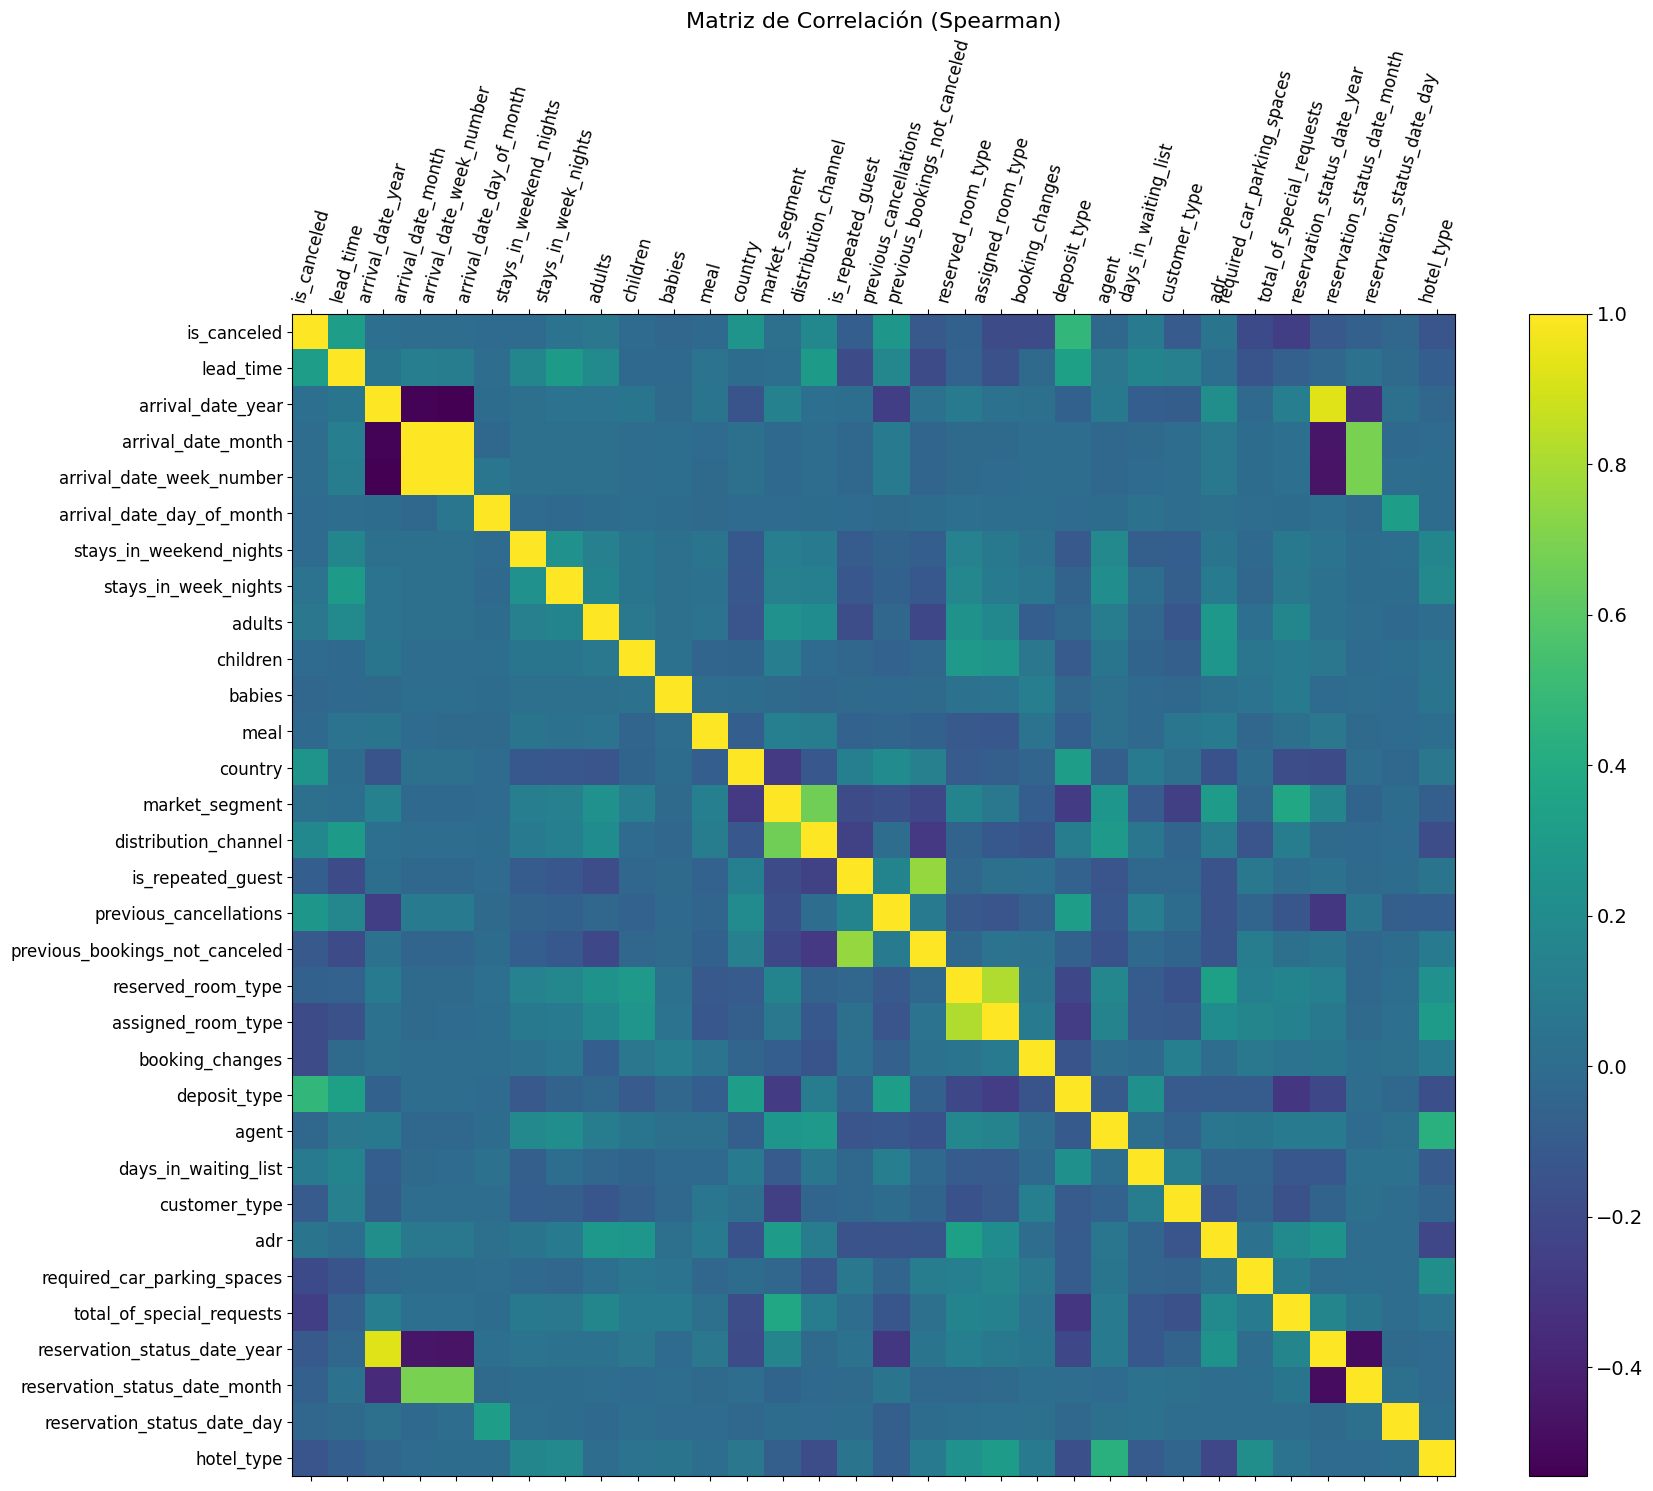

In [ ]:
# ccalculate correlation matrix
corr_matrix = data2.corr('spearman')

# plot correlation matrix
fig = plt.figure(figsize=(19,15))
plt.matshow(corr_matrix, fignum=fig)
plt.xticks(range(data2.select_dtypes(['number']).shape[1]), data2.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(data2.select_dtypes(['number']).shape[1]), data2.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix (Spearman)', fontsize=16);

In [ ]:
# get the correlations with respect to the target column
corr_cancel = corr_matrix['is_canceled'].abs().sort_values(ascending=False)
corr_cancel

# show the variables with the highest correlation
list((corr_cancel[(corr_cancel.index != 'is_canceled') & (corr_cancel > 0.10)]).index)

['deposit_type',
 'lead_time',
 'previous_cancellations',
 'total_of_special_requests',
 'country',
 'required_car_parking_spaces',
 'assigned_room_type',
 'booking_changes',
 'distribution_channel',
 'hotel_type',
 'previous_bookings_not_canceled',
 'reservation_status_date_year']

We consider variables that have a correlation greater than **10%**, and extract a total of 12 features that are likely to be the best ones to predict for our model. We include the price (adr) even though it is not shown because it is reasonable to assume that it influences the cancellation rate.

In [ ]:
# save list of features for model
features = ['deposit_type', 'lead_time', 'country', 'total_of_special_requests',
            'previous_cancellations', 'required_car_parking_spaces',
            'assigned_room_type', 'distribution_channel', 'booking_changes',
            'hotel', 'previous_bookings_not_canceled', 'reservation_status_date_year', 'adr']

target = 'is_canceled'

**Separation of data sets**

Once the variables to be used in our models have been chosen, it is necessary to start by separating the data into a training set and a validation set. We follow the standard methodology where 70% of the original set will be for training, and 30% will be for validation.

In [ ]:
# quitar nulos
data = data.dropna()

# split features and target
X = data[features]
y = data[target]

# separation of training and validation sets (scikit-learn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
X_train.shape, X_test.shape

((83573, 13), (35817, 13))

In [ ]:
X.shape

(119390, 13)

**Categorical coding (post-splitting)**

To avoid data leakage, variable encoding must be done after splitting. We now proceed to perform the coding of categorical variables separately for the training and validation sets.

In [ ]:
# define categorical encoders
lbl_enc = LabelEncoder()
hot_enc = OneHotEncoder(drop='first', sparse=False)

In [ ]:
# TOTAL DATASET
X.reset_index(inplace=True)
X.drop('index', axis=1, inplace=True)

total_size = X.shape[0]

col_name = 'hotel'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (total_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X = pd.concat([X, col_df], axis=1)
X.drop(col_name, axis=1, inplace=True)

col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

col_name = 'country'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

col_name = 'reservation_status_date_year'
X[col_name] = X[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})

In [ ]:
# TRAINING DATASET
X_train.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)

train_size = X_train.shape[0]

col_name = 'hotel'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (train_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X_train = pd.concat([X_train, col_df], axis=1)
X_train.drop(col_name, axis=1, inplace=True)

col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

col_name = 'country'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

col_name = 'reservation_status_date_year'
X_train[col_name] = X_train[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})


X_train.head(5)

In [ ]:
# VALIDATION DATASET
X_test.reset_index(inplace=True)
X_test.drop('index', axis=1, inplace=True)

test_size = X_test.shape[0]

col_name = 'hotel'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (test_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X_test = pd.concat([X_test, col_df], axis=1)
X_test.drop(col_name, axis=1, inplace=True)

col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

col_name = 'country'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

col_name = 'reservation_status_date_year'
X_test[col_name] = X_test[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})


X_test.head(5)

**Renormalization**

Since we have a large range of numerical variables, we renormalize the training and validation sets separately. This will help improve the performance of the models.

In [ ]:
# numerical columns
num_cols = ['lead_time', 'total_of_special_requests', 'previous_cancellations',
            'required_car_parking_spaces', 'booking_changes', 'previous_bookings_not_canceled', 'adr']

for col in num_cols:
  print(col, max(X_train[col]))

lead_time 2.0012901084703705
total_of_special_requests 5
previous_cancellations 5
required_car_parking_spaces 8
booking_changes 5
previous_bookings_not_canceled 1
adr 2.067970345786057


In [ ]:
# TOTAL DATASET

# standarization of 'lead_time
col_name = 'lead_time'
X[col_name] = np.log(X[col_name]+1)

# standarization of 'adr
col_name = 'adr'
X[col_name] = np.log(X[col_name]+1)
X[col_name] = X[col_name].fillna(value=X[col_name].mean())

X.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,1.922456,135,0,0,0,2,1,3,0,1,0.000000,1.0
1,0,2.001290,135,0,0,0,2,1,4,0,1,0.000000,1.0
2,0,1.124748,59,0,0,0,2,1,0,0,1,1.673489,1.0


In [ ]:
# TRAINING DATASET

# standarization 'lead_time
col_name = 'lead_time'
X_train[col_name] = np.log(X[col_name]+1)

# standarization 'adr
col_name = 'adr'
X_train[col_name] = np.log(X[col_name]+1)
X_train[col_name] = X_train[col_name].fillna(value=X_train[col_name].mean())

X_train.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,1.072424,69,0,0,0,0,3,0,0,2,0.000000,0.0
1,0,1.099042,51,2,0,0,0,3,0,0,3,0.000000,0.0
2,0,0.753653,123,2,0,0,0,3,1,1,2,0.983384,0.0


In [ ]:
# VALIDATION DATASET

# standarization 'lead_time
col_name = 'lead_time'
X_test[col_name] = np.log(X[col_name]+1)

# standarization 'adr
col_name = 'adr'
X_test[col_name] = np.log(X[col_name]+1)
X_test[col_name] = X_test[col_name].fillna(value=X_test[col_name].mean())


X_test.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,1.072424,50,0,0,0,0,3,0,0,2,0.000000,1.0
1,0,1.099042,36,0,0,0,0,3,0,0,3,0.000000,0.0
2,1,0.753653,115,0,1,0,0,3,0,0,1,0.983384,0.0


We now proceed to make the predictions with three models. Although the exercise only requests the cross validation metric (*cross validation score*), since we have divided the training and validation sets we can additionally calculate additional metrics that will allow us to complement said information.

## Predictive model (Logistic Regression)

In [ ]:
# define and train model
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

# predictions
lgr_pred = lgr.predict(X_test)

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, lgr_pred)
print('CONFUSION MATRIX')
print(conf_matrix)

# evaluation metric
accuracy = accuracy_score(y_test, lgr_pred)
print('ACCURACY')
print(round(accuracy,4))

recall = recall_score(y_test, lgr_pred)
print('RECALL')
print(round(recall,4))

f1 = f1_score(y_test, lgr_pred)
print('F1 SCORE')
print(round(f1,4))

MATRIX DE CONFUSION
[[21835   536]
 [ 7922  5524]]
PRECISIÓN
0.7639
RECALL
0.4108
MÉTRICA F1
0.5664


In [ ]:
val_score = cross_val_score(lgr, X_train, y_train, cv=4)
print('CROSS-VALIDATION SCORE (K-FOLD = 4)')
print(round(np.mean(val_score),4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.7705


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
# create results dataframe
df_res = pd.DataFrame({'Cancelación (Observado)': y_test, 'Cancelación (Predicho)': lgr_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type,Cancelación (Observado),Cancelación (Predicho)
46,0,0.999985,71,0,0,0,3,3,0,0,3,0.966211,0.0,1,0
1157,0,0.929876,50,1,0,0,0,3,0,0,2,1.035668,1.0,1,0
7824,0,1.071090,21,1,0,0,2,3,1,0,3,0.987391,1.0,0,0
9350,0,1.002638,29,0,0,1,6,3,0,0,1,0.922790,1.0,0,0
16707,0,0.986087,25,1,0,0,0,3,2,0,2,1.034452,0.0,1,0
27150,0,1.020956,29,2,0,0,0,3,0,0,1,1.037946,0.0,0,0
27523,0,1.045551,144,0,0,0,6,1,0,0,2,0.964760,0.0,0,0
31369,0,0.625800,115,1,0,0,5,3,0,0,2,0.991126,1.0,1,0
32008,1,0.798928,115,0,0,0,0,3,0,0,1,0.950717,0.0,1,1
34670,0,0.786048,47,1,0,0,0,3,0,0,3,0.967505,0.0,1,0


## Predictive model (XG Boost)

In [ ]:
# define and train model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# predictions
xgb_pred = xgb.predict(X_test)

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_pred)
print('CONFUSION MATRIX')
print(conf_matrix)

# evaluation metrix
accuracy = accuracy_score(y_test, xgb_pred)
print('ACCURACY')
print(round(accuracy,4))

recall = recall_score(y_test, xgb_pred)
print('RECALL')
print(round(recall,4))

f1 = f1_score(y_test, xgb_pred)
print('F1 SCORE')
print(round(f1,4))

MATRIX DE CONFUSION
[[21161  1210]
 [ 7083  6363]]
PRECISIÓN
0.7685
RECALL
0.4732
MÉTRICA F1
0.6055


In [ ]:
val_score = cross_val_score(xgb, X_train, y_train, cv=4)
print('PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)')
print(round(np.mean(val_score),4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.8004


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
# crear dataframe de resultados
df_res = pd.DataFrame({'Cancelación (Observado)': y_test, 'Cancelación (Predicho)': lgr_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type,Cancelación (Observado),Cancelación (Predicho)
915,0,1.023165,50,1,0,0,1,3,0,0,2,1.035668,0.0,0,0
2916,0,0.925237,115,1,0,0,2,3,0,0,1,0.927597,1.0,0,0
11833,0,0.863863,115,2,0,0,0,3,0,0,1,0.995738,1.0,1,0
17767,0,1.063164,115,0,0,0,0,3,0,0,2,0.944800,0.0,1,0
29372,1,1.041317,115,0,0,0,0,3,0,0,1,0.968950,0.0,1,1
30427,0,0.922790,0,0,0,0,3,3,0,0,2,0.973741,0.0,1,0
32607,0,0.942082,36,0,0,0,0,3,1,0,3,0.950717,0.0,0,0
34934,1,0.000000,115,0,0,0,0,3,0,0,1,1.008737,0.0,1,1
35046,0,0.810237,50,1,0,0,4,3,1,1,1,1.012615,1.0,0,0
35276,1,0.753653,115,0,1,0,0,3,0,0,1,0.990318,0.0,1,1


## Predictive model (Random Forest)

In [ ]:
# definir y entrenar modelo
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# realizar predicciones
rfc_pred = rfc.predict(X_test)

In [ ]:
# matriz de confusion
conf_matrix = confusion_matrix(y_test, rfc_pred)
print('MATRIX DE CONFUSION')
print(conf_matrix)

# metricas de validacion
accuracy = accuracy_score(y_test, rfc_pred)
print('PRECISIÓN')
print(round(accuracy,4))

recall = recall_score(y_test, rfc_pred)
print('RECALL')
print(round(recall,4))

f1 = f1_score(y_test, rfc_pred)
print('MÉTRICA F1')
print(round(f1,4))

MATRIX DE CONFUSION
[[20466  1905]
 [ 6587  6859]]
PRECISIÓN
0.7629
RECALL
0.5101
MÉTRICA F1
0.6176


In [ ]:
val_score = cross_val_score(rfc, X_train, y_train, cv=4)
print('PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)')
print(round(np.mean(val_score),4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.782


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
# crear dataframe de resultados
df_res = pd.DataFrame({'Cancelación (Observado)': y_test, 'Cancelación (Predicho)': lgr_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type,Cancelación (Observado),Cancelación (Predicho)
5852,0,1.194706,105,1,0,0,6,3,0,0,3,1.162283,1.0,0,0
6826,0,1.811234,50,0,0,1,0,3,0,0,2,1.624157,1.0,0,0
12546,0,1.886268,115,0,0,0,0,0,0,0,3,1.847796,1.0,1,0
19580,0,0.000000,50,2,0,0,3,3,0,0,3,1.663294,0.0,0,0
24004,0,1.634547,143,1,0,0,3,3,0,0,2,1.223156,1.0,0,0
25004,0,1.770740,36,0,0,0,0,3,0,0,2,1.685027,0.0,0,0
26658,0,1.631370,115,0,0,0,2,3,0,0,3,1.856716,1.0,1,0
27184,0,1.271150,47,1,0,0,3,3,0,0,3,1.847999,1.0,0,0
28405,0,1.718240,36,4,0,0,0,3,2,0,3,1.675938,0.0,0,0
34873,0,1.509918,115,0,0,0,0,3,0,0,2,1.678350,1.0,1,0


## Hyperparameter search

The previous models were trained with the default model parameters. However, we can improve performance by performing hyperparameter tuning.

We can do this manually based on the knowledge we have about the model, or we can automate it by searching the model, that is, iterating the model with different combinations until we find the set that maximizes the precision of the model.

**Logistic regression**

In [ ]:
# get model parameters
lgr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# perform grid search
c_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]

# to save best model
best_acc = 0.0
best_model = ''
best_params = {'C': 0}

# to save metric hbistory
c_hist = []
acc_hist = []

# start hyperparameter search
curr_acc = 0.0
for c in tqdm(c_list):
  lgr = LogisticRegression(C=c, n_jobs=4, solver='lbfgs')
  lgr.fit(X_train, y_train)
  lgr_pred = lgr.predict(X_test)
  curr_acc = accuracy_score(y_test, lgr_pred)
  if curr_acc > best_acc:
    best_acc = curr_acc
    best_params = {'C': c}
    best_model = lgr
  c_hist.append(c)
  acc_hist.append(curr_acc)

print('\n\nBest accuracy: ', round(best_acc*100, 2), '%')
print('Best params: ', best_params)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]



Best accuracy:  76.49 %
Best params:  {'C': 1.3}


We can visualize the evolution of precision with respect to the search parameters.

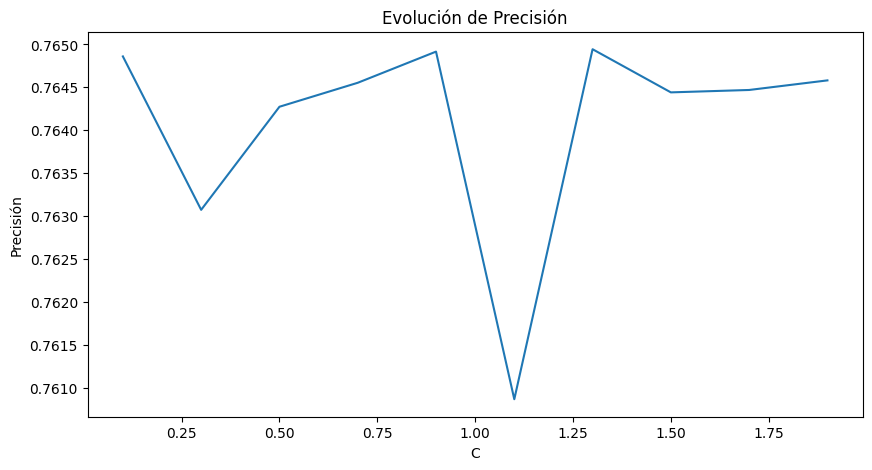

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(c_hist, acc_hist, '-')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Evolution of Accuracy')

plt.show()

We can automate this process using Scikit-learn's **GridSearch** feature.

In [ ]:
# define the default estimator
lgr = LogisticRegression()

# define parameter space (dictionary)
param_grid= {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]}

# configure network search
clf = GridSearchCV(lgr, param_grid, n_jobs=4)

# do the training
search = clf.fit(X_train, y_train)

# show results
print('best_params:', search.best_params_)
print('ACCURACY: ', round(search.score(X_test, y_test), 4))

best_params: {'C': 0.1}
PRECISIÓN:  0.7646


The above process grows rapidly with the search space size. We can use a more efficient option by performing the search randomly with **RandomizedSearchCV**, which instead of a list of parameters uses a distribution of parameters.

In [ ]:
# define the default estimator
lgr = LogisticRegression()

# define the distribution of parameters
distributions = dict(C=uniform(loc=0, scale=2), penalty=['l2', 'l1'])

# configure random network search
clf = RandomizedSearchCV(lgr, distributions, n_jobs=4)

# do the training
search = clf.fit(X_train, y_train)

# show results
print('best_params:', search.best_params_)
print('ACCURACY: ', round(search.score(X_test, y_test), 4))

best_params: {'C': 0.4728681627640412, 'penalty': 'l2'}
PRECISIÓN:  0.7634


**Random Forest**

In [ ]:
# model parameters
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# perform a grid search
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10]
max_leaf_nodes_list = [2, 3, 4, 5, 6]

# to save the best model
best_acc = 0.0
best_model = ''
best_params = {'max_depth': 0, 'max_leaf_nodes': 0}

# to save the history
max_depth_hist = []
max_leaf_nodes_hist = []
acc_hist = []

curr_acc = 0.0
for max_depth in tqdm(max_depth_list):
  for max_leaf_nodes in max_leaf_nodes_list:
    rfc = RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, n_jobs=4)
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    curr_acc = accuracy_score(y_test, rfc_pred)
    if curr_acc > best_acc:
      best_acc = curr_acc
      best_params = {'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes}
      best_model = rfc
    max_depth_hist.append(max_depth)
    max_leaf_nodes_hist.append(max_leaf_nodes)
    acc_hist.append(curr_acc)

print('\n\nBest accuracy: ', round(best_acc*100, 2), '%')
print('Best params: ', best_params)

100%|██████████| 8/8 [01:45<00:00, 13.13s/it]



Best accuracy:  76.43 %
Best params:  {'max_depth': 3, 'max_leaf_nodes': 6}


We can see the metrics of the best model.

In [ ]:
rfc_pred = best_model.predict(X_test)

# confusion matrix
conf_matrix = confusion_matrix(y_test, rfc_pred)
print('CONFUSION MATRIX')
print(conf_matrix)

# validation metrics
accuracy = accuracy_score(y_test, rfc_pred)
print('ACCURACY')
print(round(accuracy,4))

recall = recall_score(y_test, rfc_pred)
print('RECALL')
print(round(recall,4))

f1 = f1_score(y_test, rfc_pred)
print('F1 SCORE')
print(round(f1,4))

MATRIX DE CONFUSION
[[22331    40]
 [ 8401  5045]]
PRECISIÓN
0.7643
RECALL
0.3752
MÉTRICA F1
0.5445


We can visualize the evolution of precision with respect to the search parameters.

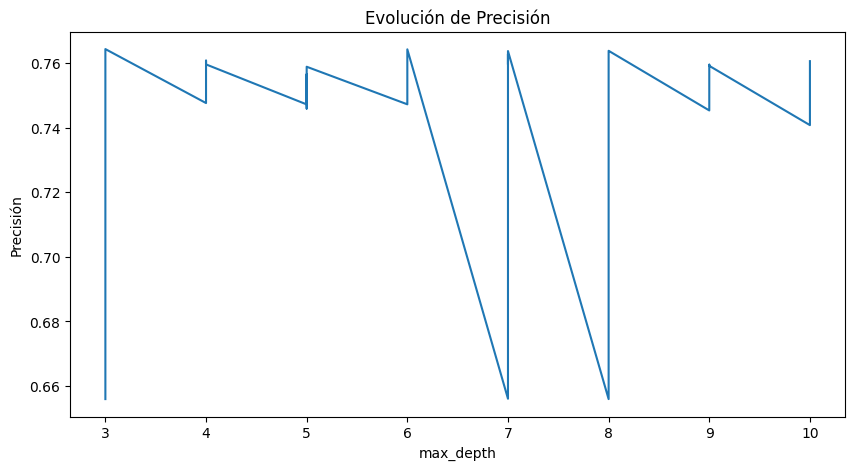

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(max_depth_hist, acc_hist, '-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Evolution of Accuracy')

plt.show()

We can automate this process using Scikit-learn's **GridSearch** feature.